# Short-Term Memory (InMemorySaver) in LangGraph

This notebook demonstrates how **short-term memory** works in LangGraph using `InMemorySaver`.

## What is Short-Term Memory?

**Short-term memory** in LangGraph refers to storing conversation history and state **temporarily in RAM**:
- ✅ Data persists **during program execution**
- ❌ Data is **lost when program stops/restarts**
- ⚡ Very fast (no disk I/O)
- 🎯 Perfect for development, testing, and temporary sessions

## Use Case: Customer Support Chatbot

We'll build a chatbot that:
1. Remembers conversation history within a session
2. Can handle multiple users simultaneously (different threads)
3. Provides context-aware responses based on chat history

## Step 1: Import Libraries and Setup

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, List
import operator
from dotenv import load_dotenv
import os
from euriai.langchain import create_chat_model
from langgraph.checkpoint.memory import InMemorySaver

load_dotenv()
api_key = os.getenv("key")

In [2]:
chat_model = create_chat_model(
    api_key=api_key,
    model="gpt-4.1-nano",
    temperature=0.7
)

## Step 2: Define State with Message History

Key point: We use `Annotated[List[str], operator.add]` to **accumulate** messages instead of overwriting them.

In [3]:
class ChatState(TypedDict):
    # Annotated[List[str], operator.add] ensures messages ACCUMULATE across turns
    # Each new message is APPENDED to the list, not replaced
    messages: Annotated[List[str], operator.add]
    
    # Current user input
    user_input: str
    
    # AI response
    ai_response: str
    
    # User name for personalization
    user_name: str

## Step 3: Create Workflow Nodes

We'll create nodes that:
1. Process user input and add to history
2. Generate AI response based on conversation history
3. Store the response in history

In [ ]:
def process_user_message(state: ChatState):
    """Add user message to conversation history"""
    user_input = state['user_input']
    user_name = state.get('user_name', 'User')
    
    # Format message with user name
    formatted_message = f"{user_name}: {user_input}"
    
    # This will be appended to messages list due to operator.add
    return {"messages": [formatted_message]}

def generate_response(state: ChatState):
    """Generate AI response based on conversation history"""
    
    # Get conversation history
    conversation_history = state.get('messages', [])
    user_name = state.get('user_name', 'User')
    
    # Build context from history
    if conversation_history:
        context = "\n".join(conversation_history)
        prompt = f"""You are a helpful customer support assistant. 
        
        Previous conversation:
        {context}
        Please provide a helpful and context-aware response to the latest message. Be friendly and reference previous conversation when relevant."""
        
    else:
        prompt = f"You are a helpful customer support assistant. Please respond to: {state['user_input']}"
    
    # Generate response
    ai_response = chat_model.invoke(prompt).content
    
    # Format AI message
    formatted_response = f"Assistant: {ai_response}"
    
    # Return both the response and add it to messages history
    return {
        "ai_response": ai_response,
        "messages": [formatted_response]
    }

## Step 4: Build the Graph with InMemorySaver

**Key: We use `InMemorySaver()` as the checkpointer** - this enables short-term memory!

In [5]:
# Create the graph
graph = StateGraph(ChatState)

# Add nodes
graph.add_node("process_user_message", process_user_message)
graph.add_node("generate_response", generate_response)

# Add edges
graph.add_edge(START, "process_user_message")
graph.add_edge("process_user_message", "generate_response")
graph.add_edge("generate_response", END)

# ⭐ Create InMemorySaver - this is the SHORT-TERM MEMORY
checkpointer = InMemorySaver()

# Compile with checkpointer
workflow = graph.compile(checkpointer=checkpointer)

print("✅ Workflow compiled with InMemorySaver (short-term memory enabled)")

✅ Workflow compiled with InMemorySaver (short-term memory enabled)


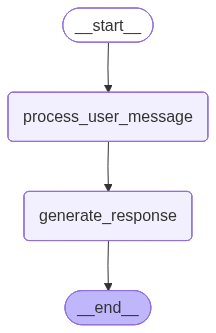

In [6]:
# Visualize the workflow
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

## Step 5: Test Short-Term Memory - Single User Conversation

Let's simulate a conversation where the chatbot **remembers** previous messages.

In [7]:
# Helper function to chat
def chat(user_input: str, thread_id: str, user_name: str = "User"):
    """Send a message and get response"""
    config = {"configurable": {"thread_id": thread_id}}
    
    result = workflow.invoke(
        {
            "user_input": user_input,
            "user_name": user_name
        },
        config=config
    )
    
    print(f"\n{user_name}: {user_input}")
    print(f"Assistant: {result['ai_response']}")
    print("-" * 80)
    
    return result

In [8]:
# Conversation 1: User Alice - Thread 1
print("=" * 80)
print("CONVERSATION WITH ALICE (Thread: alice_001)")
print("=" * 80)

# First message
chat("Hi! I need help with my order", "alice_001", "Alice")

CONVERSATION WITH ALICE (Thread: alice_001)

Alice: Hi! I need help with my order
Assistant: Hello Alice! I'd be happy to assist you with your order. Could you please provide me with your order number or let me know what specific issue you're experiencing? I'm here to help!
--------------------------------------------------------------------------------


{'messages': ['Alice: Hi! I need help with my order',
  "Assistant: Hello Alice! I'd be happy to assist you with your order. Could you please provide me with your order number or let me know what specific issue you're experiencing? I'm here to help!"],
 'user_input': 'Hi! I need help with my order',
 'ai_response': "Hello Alice! I'd be happy to assist you with your order. Could you please provide me with your order number or let me know what specific issue you're experiencing? I'm here to help!",
 'user_name': 'Alice'}

In [9]:
# Second message - AI should remember the first message!
chat("My order number is #12345", "alice_001", "Alice")


Alice: My order number is #12345
Assistant: Hello Alice! Thank you for providing your order number #12345. Could you please let me know what specific issue you're experiencing with your order? Whether it's a delay, a missing item, or anything else, I'm here to help!
--------------------------------------------------------------------------------


{'messages': ['Alice: Hi! I need help with my order',
  "Assistant: Hello Alice! I'd be happy to assist you with your order. Could you please provide me with your order number or let me know what specific issue you're experiencing? I'm here to help!",
  'Alice: My order number is #12345',
  "Assistant: Hello Alice! Thank you for providing your order number #12345. Could you please let me know what specific issue you're experiencing with your order? Whether it's a delay, a missing item, or anything else, I'm here to help!"],
 'user_input': 'My order number is #12345',
 'ai_response': "Hello Alice! Thank you for providing your order number #12345. Could you please let me know what specific issue you're experiencing with your order? Whether it's a delay, a missing item, or anything else, I'm here to help!",
 'user_name': 'Alice'}

In [10]:
# Third message - AI should remember entire conversation!
chat("When will it arrive?", "alice_001", "Alice")


Alice: When will it arrive?
Assistant: Hello Alice! Thank you for your message. Based on your order #12345, I will check the estimated delivery date for you. Please hold on a moment while I look up the details.
--------------------------------------------------------------------------------


{'messages': ['Alice: Hi! I need help with my order',
  "Assistant: Hello Alice! I'd be happy to assist you with your order. Could you please provide me with your order number or let me know what specific issue you're experiencing? I'm here to help!",
  'Alice: My order number is #12345',
  "Assistant: Hello Alice! Thank you for providing your order number #12345. Could you please let me know what specific issue you're experiencing with your order? Whether it's a delay, a missing item, or anything else, I'm here to help!",
  'Alice: When will it arrive?',
  'Assistant: Hello Alice! Thank you for your message. Based on your order #12345, I will check the estimated delivery date for you. Please hold on a moment while I look up the details.'],
 'user_input': 'When will it arrive?',
 'ai_response': 'Hello Alice! Thank you for your message. Based on your order #12345, I will check the estimated delivery date for you. Please hold on a moment while I look up the details.',
 'user_name': 'Alic

## Step 6: View Conversation History

Let's inspect what's stored in short-term memory for Alice's conversation.

In [11]:
# Get current state for Alice's thread
alice_config = {"configurable": {"thread_id": "alice_001"}}
alice_state = workflow.get_state(config=alice_config)

print("📝 Alice's Current State:")
print("\nMessages History:")
for i, msg in enumerate(alice_state.values.get('messages', []), 1):
    print(f"{i}. {msg}")

print(f"\nLast AI Response: {alice_state.values.get('ai_response', 'N/A')}")

📝 Alice's Current State:

Messages History:
1. Alice: Hi! I need help with my order
2. Assistant: Hello Alice! I'd be happy to assist you with your order. Could you please provide me with your order number or let me know what specific issue you're experiencing? I'm here to help!
3. Alice: My order number is #12345
4. Assistant: Hello Alice! Thank you for providing your order number #12345. Could you please let me know what specific issue you're experiencing with your order? Whether it's a delay, a missing item, or anything else, I'm here to help!
5. Alice: When will it arrive?
6. Assistant: Hello Alice! Thank you for your message. Based on your order #12345, I will check the estimated delivery date for you. Please hold on a moment while I look up the details.

Last AI Response: Hello Alice! Thank you for your message. Based on your order #12345, I will check the estimated delivery date for you. Please hold on a moment while I look up the details.


## Step 7: Multiple Users - Separate Threads

Short-term memory keeps conversations **isolated** by thread_id. Let's test with another user.

In [12]:
# Conversation 2: User Bob - Thread 2 (completely separate from Alice)
print("\n" + "=" * 80)
print("CONVERSATION WITH BOB (Thread: bob_002)")
print("=" * 80)

chat("Hello! Can I get a refund?", "bob_002", "Bob")


CONVERSATION WITH BOB (Thread: bob_002)

Bob: Hello! Can I get a refund?
Assistant: Hello Bob! I'd be happy to assist you with your refund request. Could you please provide some details about the purchase you'd like to refund? Once I have that information, I can guide you through the process.
--------------------------------------------------------------------------------


{'messages': ['Bob: Hello! Can I get a refund?',
  "Assistant: Hello Bob! I'd be happy to assist you with your refund request. Could you please provide some details about the purchase you'd like to refund? Once I have that information, I can guide you through the process."],
 'user_input': 'Hello! Can I get a refund?',
 'ai_response': "Hello Bob! I'd be happy to assist you with your refund request. Could you please provide some details about the purchase you'd like to refund? Once I have that information, I can guide you through the process.",
 'user_name': 'Bob'}

In [13]:
# Bob's second message
chat("I bought a laptop last week", "bob_002", "Bob")


Bob: I bought a laptop last week
Assistant: Hello Bob! Thanks for sharing that you bought a laptop last week. To assist you further with your refund request, could you please confirm if you still have the receipt or order number? Additionally, if there are any specific issues with the laptop or reasons for the refund, please let me know. I'm here to help you through the process!
--------------------------------------------------------------------------------


{'messages': ['Bob: Hello! Can I get a refund?',
  "Assistant: Hello Bob! I'd be happy to assist you with your refund request. Could you please provide some details about the purchase you'd like to refund? Once I have that information, I can guide you through the process.",
  'Bob: I bought a laptop last week',
  "Assistant: Hello Bob! Thanks for sharing that you bought a laptop last week. To assist you further with your refund request, could you please confirm if you still have the receipt or order number? Additionally, if there are any specific issues with the laptop or reasons for the refund, please let me know. I'm here to help you through the process!"],
 'user_input': 'I bought a laptop last week',
 'ai_response': "Hello Bob! Thanks for sharing that you bought a laptop last week. To assist you further with your refund request, could you please confirm if you still have the receipt or order number? Additionally, if there are any specific issues with the laptop or reasons for the r

In [14]:
# Check Bob's state - should be different from Alice's
bob_config = {"configurable": {"thread_id": "bob_002"}}
bob_state = workflow.get_state(config=bob_config)

print("📝 Bob's Current State:")
print("\nMessages History:")
for i, msg in enumerate(bob_state.values.get('messages', []), 1):
    print(f"{i}. {msg}")

📝 Bob's Current State:

Messages History:
1. Bob: Hello! Can I get a refund?
2. Assistant: Hello Bob! I'd be happy to assist you with your refund request. Could you please provide some details about the purchase you'd like to refund? Once I have that information, I can guide you through the process.
3. Bob: I bought a laptop last week
4. Assistant: Hello Bob! Thanks for sharing that you bought a laptop last week. To assist you further with your refund request, could you please confirm if you still have the receipt or order number? Additionally, if there are any specific issues with the laptop or reasons for the refund, please let me know. I'm here to help you through the process!


## Step 8: Compare Both Conversations

Let's verify that both conversations are **completely isolated** in memory.

In [15]:
print("=" * 80)
print("COMPARISON: Alice vs Bob")
print("=" * 80)

alice_state = workflow.get_state(config={"configurable": {"thread_id": "alice_001"}})
bob_state = workflow.get_state(config={"configurable": {"thread_id": "bob_002"}})

print("\n👩 ALICE'S CONVERSATION:")
print("-" * 40)
for msg in alice_state.values.get('messages', []):
    print(msg)

print("\n\n👨 BOB'S CONVERSATION:")
print("-" * 40)
for msg in bob_state.values.get('messages', []):
    print(msg)

print("\n✅ Both conversations are completely isolated!")

COMPARISON: Alice vs Bob

👩 ALICE'S CONVERSATION:
----------------------------------------
Alice: Hi! I need help with my order
Assistant: Hello Alice! I'd be happy to assist you with your order. Could you please provide me with your order number or let me know what specific issue you're experiencing? I'm here to help!
Alice: My order number is #12345
Assistant: Hello Alice! Thank you for providing your order number #12345. Could you please let me know what specific issue you're experiencing with your order? Whether it's a delay, a missing item, or anything else, I'm here to help!
Alice: When will it arrive?
Assistant: Hello Alice! Thank you for your message. Based on your order #12345, I will check the estimated delivery date for you. Please hold on a moment while I look up the details.


👨 BOB'S CONVERSATION:
----------------------------------------
Bob: Hello! Can I get a refund?
Assistant: Hello Bob! I'd be happy to assist you with your refund request. Could you please provide some

## Step 9: View Full History for a Thread

We can see **every checkpoint** (state snapshot) in the conversation history.

In [16]:
# Get full history for Alice's thread
alice_history = list(workflow.get_state_history(config={"configurable": {"thread_id": "alice_001"}}))

print(f"📚 Alice's conversation has {len(alice_history)} checkpoints\n")

# Show each checkpoint (in reverse chronological order)
for i, checkpoint in enumerate(alice_history):
    print(f"Checkpoint {i + 1}:")
    print(f"  Messages count: {len(checkpoint.values.get('messages', []))}")
    print(f"  Last user input: {checkpoint.values.get('user_input', 'N/A')}")
    print(f"  Node: {checkpoint.next}")
    print("-" * 60)

📚 Alice's conversation has 12 checkpoints

Checkpoint 1:
  Messages count: 6
  Last user input: When will it arrive?
  Node: ()
------------------------------------------------------------
Checkpoint 2:
  Messages count: 5
  Last user input: When will it arrive?
  Node: ('generate_response',)
------------------------------------------------------------
Checkpoint 3:
  Messages count: 4
  Last user input: When will it arrive?
  Node: ('process_user_message',)
------------------------------------------------------------
Checkpoint 4:
  Messages count: 4
  Last user input: My order number is #12345
  Node: ('__start__',)
------------------------------------------------------------
Checkpoint 5:
  Messages count: 4
  Last user input: My order number is #12345
  Node: ()
------------------------------------------------------------
Checkpoint 6:
  Messages count: 3
  Last user input: My order number is #12345
  Node: ('generate_response',)
----------------------------------------------------

## Step 10: What Happens When Program Restarts?

⚠️ **Important Limitation of InMemorySaver (Short-Term Memory):**

```python
# If you restart this notebook kernel:
# 1. All conversation history is LOST ❌
# 2. Alice's and Bob's threads are GONE ❌
# 3. You start fresh with empty memory
```

**Why?** Because `InMemorySaver` stores data in RAM, which is cleared on restart.

**Solution for Persistence:**
```python
from langgraph.checkpoint.sqlite import SqliteSaver

# Use SqliteSaver instead - data survives restarts! ✅
checkpointer = SqliteSaver.from_conn_string("chat_history.db")
workflow = graph.compile(checkpointer=checkpointer)
```

## Summary: InMemorySaver (Short-Term Memory)

### ✅ What It Does:
1. **Stores conversation state in RAM** during program execution
2. **Isolates conversations** by `thread_id`
3. **Accumulates messages** across turns using `Annotated[List, operator.add]`
4. **Provides context** for AI to generate relevant responses
5. **Very fast** - no disk I/O

### ❌ Limitations:
1. **Data lost on restart** - not persistent
2. **Not suitable for production** if you need conversation history across sessions
3. **Limited by RAM** - can't scale indefinitely

### 🎯 Best Use Cases:
- Development and testing
- Temporary chat sessions
- Demos and prototypes
- Single-session workflows

### 🔄 Alternatives:
- **SqliteSaver** - File-based persistence
- **PostgresSaver** - Database persistence for production
- **RedisSaver** - Fast distributed caching

---

**Key Takeaway:** `InMemorySaver` is perfect for **temporary, fast, in-session memory** but not for long-term persistence! 🧠💨